In [42]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import time
import numpy as np
from scipy import interpolate
from scipy.signal import find_peaks
import trackpy as tp
import cv2 as cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import trackpy as tp
import scipy as sc
import matplotlib.colors as colors
import os
from ipywidgets import HBox, Textarea, interact

%matplotlib inline
def l2n(x): 
    return np.asarray(x)

In [43]:
def _autoCorr(v,maxLag):
    vac = np.zeros(maxLag) #initialize the correlation function
    vMag = np.sum(np.sqrt(v*v),axis=0) #velocity magnitudes
    
    vac[0] = np.mean( np.sum( v*v ,axis=0)/(vMag*vMag));

    for tau in range(1,maxLag):            
        vac[tau] = np.mean( np.sum( v[:,tau:]*v[:,:-tau]/(vMag[tau:]*vMag[:-tau]) ,axis=0));
  
    return vac

def velocityTimeAutoCorrelation(t,r,maxLag=10):
    #Return the autocorelation of an instanteneous veolocity 
    #t - time, x - a position vector
    maxLag = min(maxLag,len(t)-1)

    tt = np.zeros(r.shape[0])+t[:,None]
    tt = tt.T
    v = np.diff(r)/np.diff(tt)

    vac = _autoCorr(v,maxLag)
    return vac

def calcInstantaneousCurvature(r):
    
    #calculates the local curvature at every point
    #r is a vector array of location
    
    #calculate difference between positions 3&1 and 2&1
    a = (np.roll(r,-2)-r)[:,:-2]
    b = (np.roll(r,-1)-r)[:,:-2]
    aNorm = np.linalg.norm(a)
    bNorm = np.linalg.norm(b)
    sinTheta = np.cross(a,b,axis=0)/(aNorm*bNorm)

    R = (a-b)/(2*sinTheta)

    return R


def calcWindowVectorCurvature(r,halfWindow=1):
    
    window=halfWindow*2
    
    #calculates the local curvature at every point
    #r is a vector array of location
    
    #calculate difference between positions 3&1 and 2&1
    a = (np.roll(r,-window)-r)[:,:-window]
    b = (np.roll(r,-halfWindow)-r)[:,:-window]
    aNorm = np.linalg.norm(a,axis=0)
    bNorm = np.linalg.norm(b,axis=0)
    sinTheta = np.cross(a,b,axis=0)/(aNorm*bNorm)

    R = (a-b)/(2*sinTheta)

    return R

def calcWindowScalarCurvature(r,halfWindow=1):
    
    window=halfWindow*2
    
    #calculates the local curvature at every point
    #r is a vector array of location
    
    #calculate difference between positions 3&1 and 2&1
    a = (np.roll(r,-window)-r)[:,:-window]
    b = (np.roll(r,-halfWindow)-r)[:,:-window]
    aNorm = np.linalg.norm(a,axis=0)
    bNorm = np.linalg.norm(b,axis=0)
    sinTheta = np.cross(a,b,axis=0)/(aNorm*bNorm)

    R = np.linalg.norm(a-b,axis=0)/(2*sinTheta)

    return R

def calcWindowTangent(r,window=1):
    #computer the local tangent.
    
    #calculates the local curvature at every point
    #r is a vector array of location
    
    #calculate difference between positions 3&1 and 2&1
    a = (np.roll(r,-window)-r)[:,:-window]
    
    
    return a
def calcRadiusCurvature(x,y,window=1):
    dx=np.diff(x,n=window)
    new_dx=dx[:len(dx)-window]
    dy=np.diff(y,n=window)
    new_dy=dy[:len(dy)-window]
    ddx=np.diff(dx,n=window)
    ddy=np.diff(dy,n=window)
    R_before_norm=np.power(np.power(new_dx,2)+np.power(new_dy,2),(3/2))/(new_dx*ddy-new_dy*ddx)
    #R=np.linalg.norm(R_before_norm)
    return R_before_norm

def calcVelocityTheta(x,y,t,window):
    diff_x=np.diff(x)
    diff_y=np.diff(y)
    diff_t=np.diff(t)
    x=x[1:]
    y=y[1:]
    t=t[1:]
    vx=diff_x/diff_t
    vy=diff_y/diff_t
    vphi=-y/(np.power(x,2)+np.power(y,2))*vx+x/(np.power(x,2)+np.power(y,2))*vy
    return vphi

def calcVelocity(x,y,t,window):
    a_X=(np.roll(x,-window)-x)[:-window]
    a_Y=(np.roll(y,-window)-y)[:-window]
    a_t=(np.roll(t,-window)-t)[:-window]
    v=np.sqrt(np.power((a_X/a_t),2)+np.power((a_Y/a_t),2))
    return v
def calcVelocityPhi(x,y,t,window):
    phi=np.arctan2(y,x) + (np.arctan2(y,x)<0).astype(int)*2*np.pi
    dphi=(np.roll(phi,-window)-phi)[:-window]
    dt=(np.roll(t,-window)-t)[:-window]
    Vphi=dphi/dt
    return Vphi

def read_time(time_value):
    fps=25
    sign_index=time_value.index(':')
    minutes=int(time_value[0:sign_index])
    sec=int(time_value[sign_index+1:len(time_value)])
    frames=(minutes*60+sec)*25
    return frames
#def expShift(t,A,tau,k):
#    return A*np.exp(-t/tau)+k
def expShift(t,A,tau,k):
    return A*np.exp(-(t**2)/((tau**2)))+k
#def CovToCorr(cov_data):
#    shape=cov_data.shape
#    result=[]
#    for i in range(0,shape):
def powerlaw(x,A,n):
    return A*x**n
def linear_fit_log(x,n,A):
    return n*x+A
    

In [44]:
folder_name='D:\\Eden\\new_exp_test_15_11_23\\5_2_24'
linking_file_name='C0654.MP4_locatedFull20240306_bot_Eden.csv_linked.csv'
linkedDataFileName = '{}\\{}'.format(folder_name,linking_file_name)
tl = pd.read_csv(linkedDataFileName)
tl.head()

,frame,frame.1,x,y,r,particle
0,65,65,503.5,772.5,30.0,0
1,67,67,501.5,763.5,30.0,0
2,70,70,501.5,754.5,31.1,0
3,71,71,500.5,754.5,29.9,0
4,72,72,502.5,751.5,31.0,0


                         0
lag time [s]              
0.04          8.163919e+02
0.08          2.187356e+03
0.12          4.465497e+03
0.16          7.656322e+03
0.20          1.175614e+04
...                    ...
317.88        1.368899e+07
317.92        1.371852e+07
317.96        1.371368e+07
318.00        1.414048e+07
318.04        1.405486e+07

[7951 rows x 1 columns]
[ 1.8508723  12.47943096]
[0.00758538 0.0076902 ]


Text(0, 0.5, 'MSD $\\left[\\rm{cm}^2\\right]$')

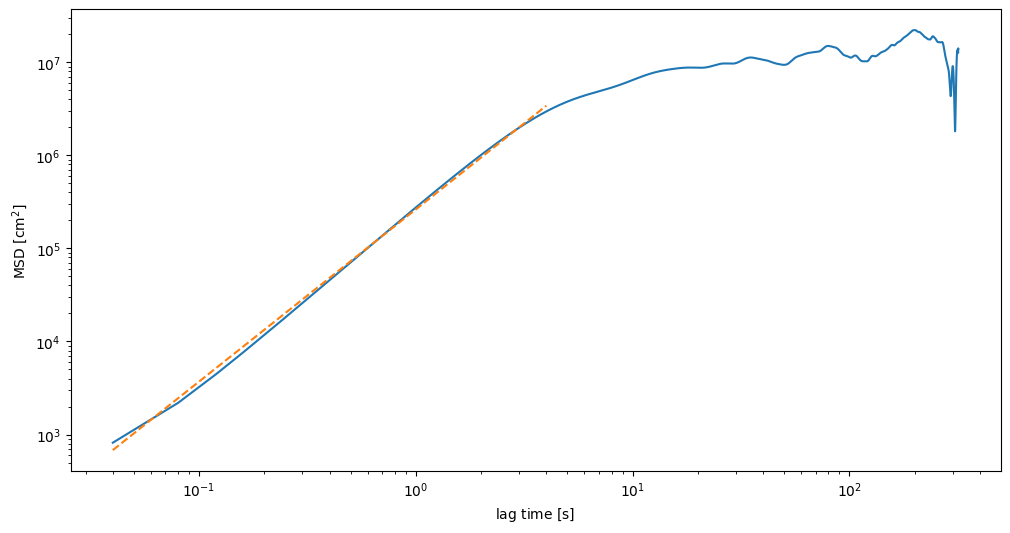

In [49]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
fps=25
arenaSizePixelsx = 960 # [pixels]
arenaSizePixelsy=960
arenaSizeCm = 100#
mmp=arenaSizePixelsx/arenaSizeCm
relevant_data_try = tp.filter_stubs(tl,threshold=100)
#max_lagtime=int(len(relevant_data_try)/3)
imsd_try = tp.imsd(relevant_data_try,fps=fps,mpp=mmp,max_lagtime=300000)
print(imsd_try)
ax.loglog(imsd_try[(imsd_try>0)].index,imsd_try[imsd_try>0],label='msd')
relevant_imsd=imsd_try.loc[0:4]

p0=np.array([2,0.5])
popt,pcov = sc.optimize.curve_fit(linear_fit_log,np.log(relevant_imsd.index),np.log(relevant_imsd.iloc[:,0]),p0=p0)
perr = np.sqrt(np.diag(pcov))
corr=np.corrcoef(pcov,rowvar=True)
print(popt)
print(perr)
fit_x=np.log(relevant_imsd.index)
fit_y=fit_x*popt[0]+popt[1]
ax.loglog(np.exp(fit_x),np.exp(fit_y),'--')
ax.set_xlabel(r'lag time $\left[\rm{s}\right]$')
ax.set_ylabel(r'MSD $\left[\rm{cm}^2\right]$')